In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
# %load_ext autoreload
# %autoreload 2

from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
import pyfolio as pf

from src.strategy import StatisticalArbitrageCointegration, CustomData

idx = pd.IndexSlice

In [18]:
DATA_PATH = r"data"
BACKTEST =  DATA_PATH + r"\backtest.h5"
UNIVERSE = DATA_PATH + r"\etfs_stocks_universe.h5"
ASSETS = DATA_PATH + r"\assets.h5"

In [19]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

##### Load Trades

In [20]:
with pd.HDFStore(BACKTEST) as store:
    trades = store['test_spy_top5-2/trades'].sort_index()
    prices = store['prices'].sort_index()

In [6]:
# trades = trades[(trades['period'] > 6) & (trades['period'] <= 8)].sort_index()

In [21]:
trade_dates = np.unique(trades.index)
start = trade_dates.min()
end = trade_dates.max()
traded_symbols = pd.concat([trades.s1, trades.s2]).unique()

prices = prices.loc[idx[traded_symbols, str(start):str(end)], :]

In [22]:
trades

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2018-01-02,D.US,SPY.US,-0.265354,1,1,-1
2018-01-02,DD.US,SPY.US,-0.371571,1,3,1
2018-01-02,GME.US,SPY.US,-0.015997,1,4,1
2018-01-02,SPY.US,MPC.US,-4.413097,1,2,-1
2018-01-02,SPY.US,AXP.US,-2.642100,1,5,1
...,...,...,...,...,...,...
2022-11-28,SPY.US,MPC.US,-3.130123,1,2,0
2022-12-14,SPY.US,AXP.US,-2.534744,1,5,1
2022-12-15,SPY.US,MPC.US,-3.422706,1,2,-1


##### Configure Cerebro, Add Data, and Add Strategy & Analyzer

In [23]:
cerebro = bt.Cerebro()
cash = 1000000
cerebro.broker.setcash(cash)

for symbol in traded_symbols:
    df = prices.loc[idx[symbol, :], :].droplevel('ticker', axis = 0)
    df.index.name = 'datetime'
    bt_data = CustomData(dataname = df)
    cerebro.adddata(bt_data, name = symbol)

cerebro.addstrategy(StatisticalArbitrageCointegration,
                    trades = trades, risk_limit = -0.2, verbose = True, 
                    log_file = r'C:\Personal\2. Projects\pairs-trading\docs\Backtest logs\log_spy_top5-2.csv')

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'pyfolio')

##### Run Strategy

In [24]:
start = time()
results = cerebro.run()

ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f} | Duration: {format_time(duration)}')

2018-04-19 00:00:00 PF:   1,068,390 | Net:    -956,539 | # Pos:   1 | # Pairs:   0 |Long:          0 | Short:   -956,539
2018-05-22 00:00:00 PF:     980,963 | Net:    -983,197 | # Pos:   2 | # Pairs:   0 |Long:  1,002,365 | Short: -1,985,563
2018-06-25 00:00:00 PF:     972,964 | Net:    -968,421 | # Pos:   1 | # Pairs:   0 |Long:          0 | Short:   -968,421
2019-01-24 00:00:00 PF:     898,699 | Net:    -951,510 | # Pos:   1 | # Pairs:   0 |Long:          0 | Short:   -951,510
2019-04-16 00:00:00 PF:     712,779 | Net:  -1,109,262 | # Pos:   2 | # Pairs:   0 |Long:    751,337 | Short: -1,860,599
2019-12-16 00:00:00 PF:     717,398 | Net:  -1,275,567 | # Pos:   3 | # Pairs:   0 |Long:  1,934,750 | Short: -3,210,317
2020-02-27 00:00:00 PF:     630,106 | Net:  -1,286,265 | # Pos:   3 | # Pairs:   0 |Long:    807,420 | Short: -2,093,685
2020-04-09 00:00:00 PF:     378,510 | Net:  -1,565,331 | # Pos:   3 | # Pairs:   0 |Long:    945,868 | Short: -2,511,199
2020-06-11 00:00:00 PF:     273,

Get PyFolio Inputs

In [25]:
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [22]:
# returns.to_hdf(STORE, 'test6/returns')
# positions.to_hdf(STORE, 'test6/positions')
# transactions.to_hdf(STORE, 'test6/transactions')
# gross_lev.to_hdf(STORE, 'test6/gross_lev')

In [66]:
# with pd.HDFStore(STORE) as store:
#     returns = store['test1/returns']
#     positions = store['test1/positions']
#     transactions = store['test1/transactions']
#     gross_lev = store['test1/gross_lev']
#     traded_pairs = store['test1/traded_pairs']
#     metrics = store['test1/metrics']

##### Get Positions

In [239]:
# traded_pairs = pd.DataFrame(results[0].exposure)
# traded_pairs.date = pd.to_datetime(traded_pairs.date)
# traded_pairs = traded_pairs.set_index('date').tz_localize('UTC')
# traded_pairs.to_hdf(STORE, 'test6/traded_pairs')

##### Get Metrics

In [240]:
# metrics = pd.DataFrame(results[0].metrics,
#                        columns = ['date', 'pf', 'net_holdings', 'cash',
#                                   'npositions', 'npairs', 'nlong_pos', 'nshort_pos',
#                                   'target', 'target_val', 'nlong_trades',
#                                   'nshort_trades', 'nclose_trades'])
# metrics.to_hdf(STORE, 'test6/metrics')

### Run PyFolio Analysis

##### Create full tearsheet

Start date,2018-01-02
End date,2022-12-29
Total months,59
,Backtest
Annual return,-9.175%
Cumulative returns,-38.146%
Annual volatility,2082.657%
Sharpe ratio,-0.09
Calmar ratio,-0.06
Stability,NaN
Max drawdown,-150.808%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,150.81,2018-03-27,2021-12-29,NaT,NaN
1,7.51,2018-02-08,2018-03-09,2018-03-22,31
2,1.36,2018-02-05,2018-02-06,2018-02-08,4
3,1.36,2018-03-23,2018-03-26,2018-03-27,3
4,1.32,2018-01-23,2018-01-24,2018-01-25,3


Stress Events,mean,min,max
New Normal,-0.10%,-4.37%,4.29%
Covid,-1.20%,-4177.99%,1284.05%


Top 10 long positions of all time,max
AXP.US,15665.96%


Top 10 short positions of all time,max
AXP.US,-126.25%


Top 10 positions of all time,max
AXP.US,15665.96%


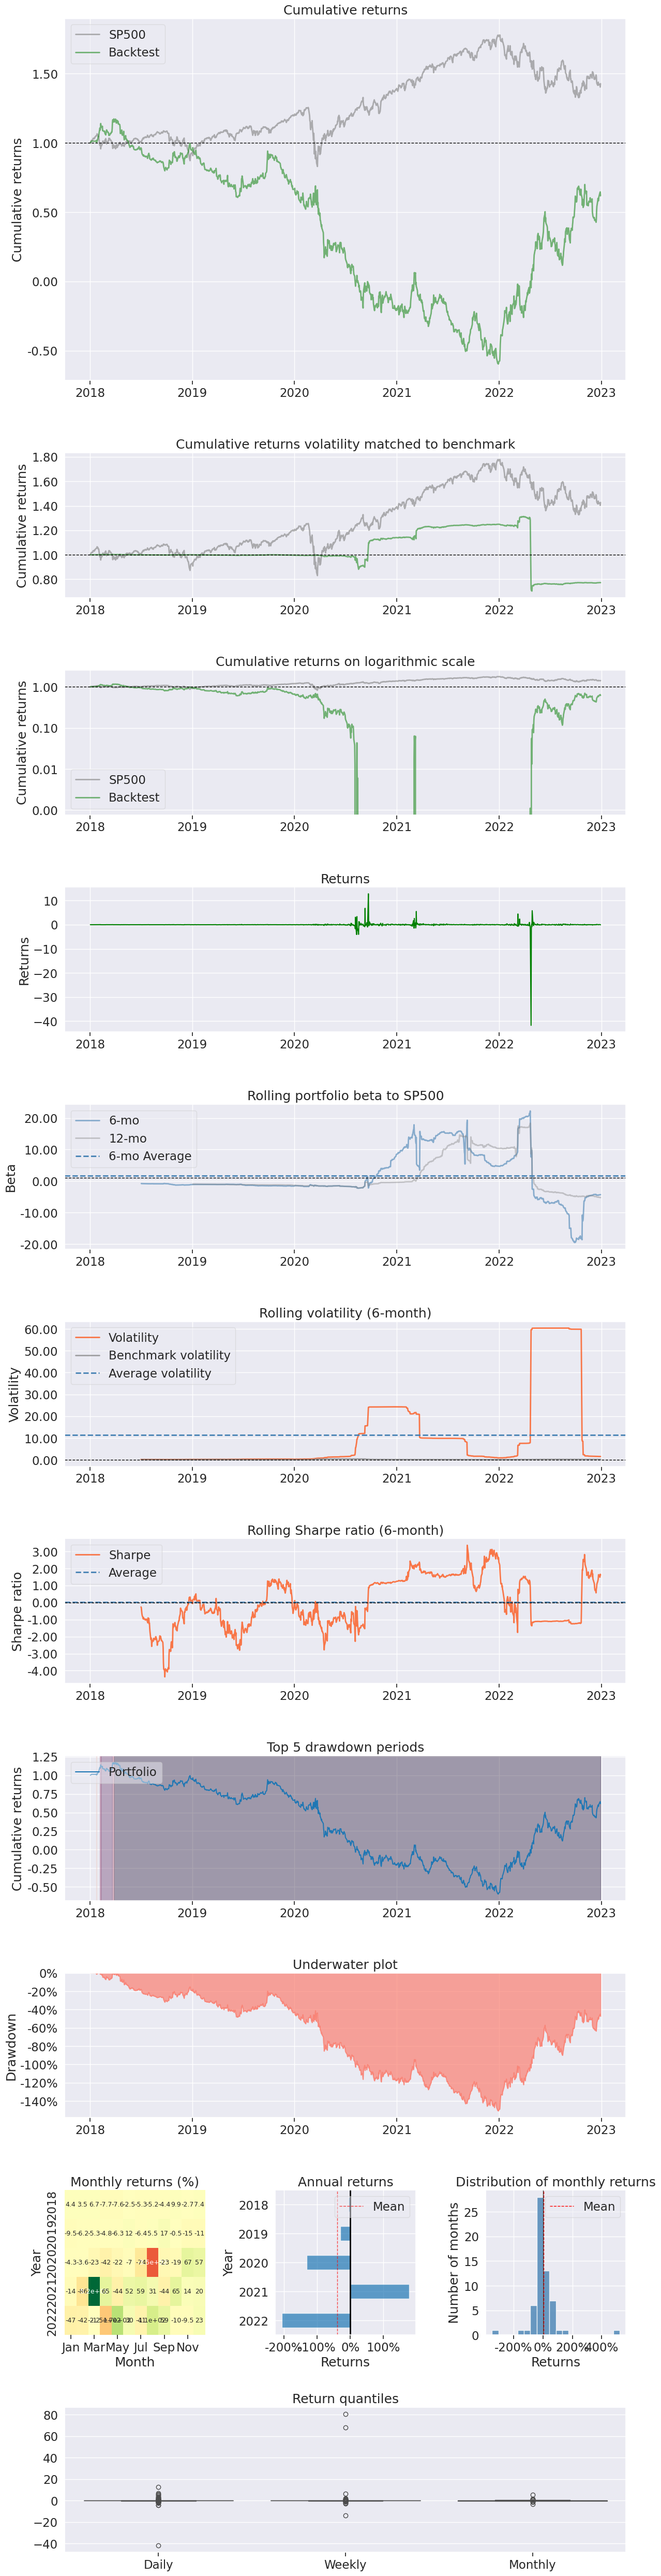

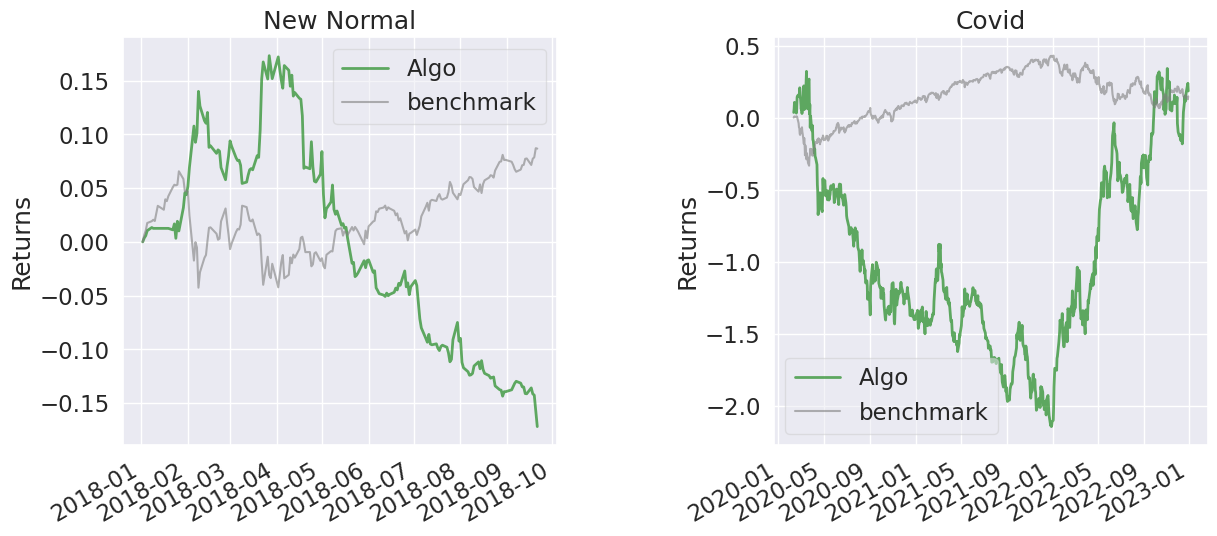

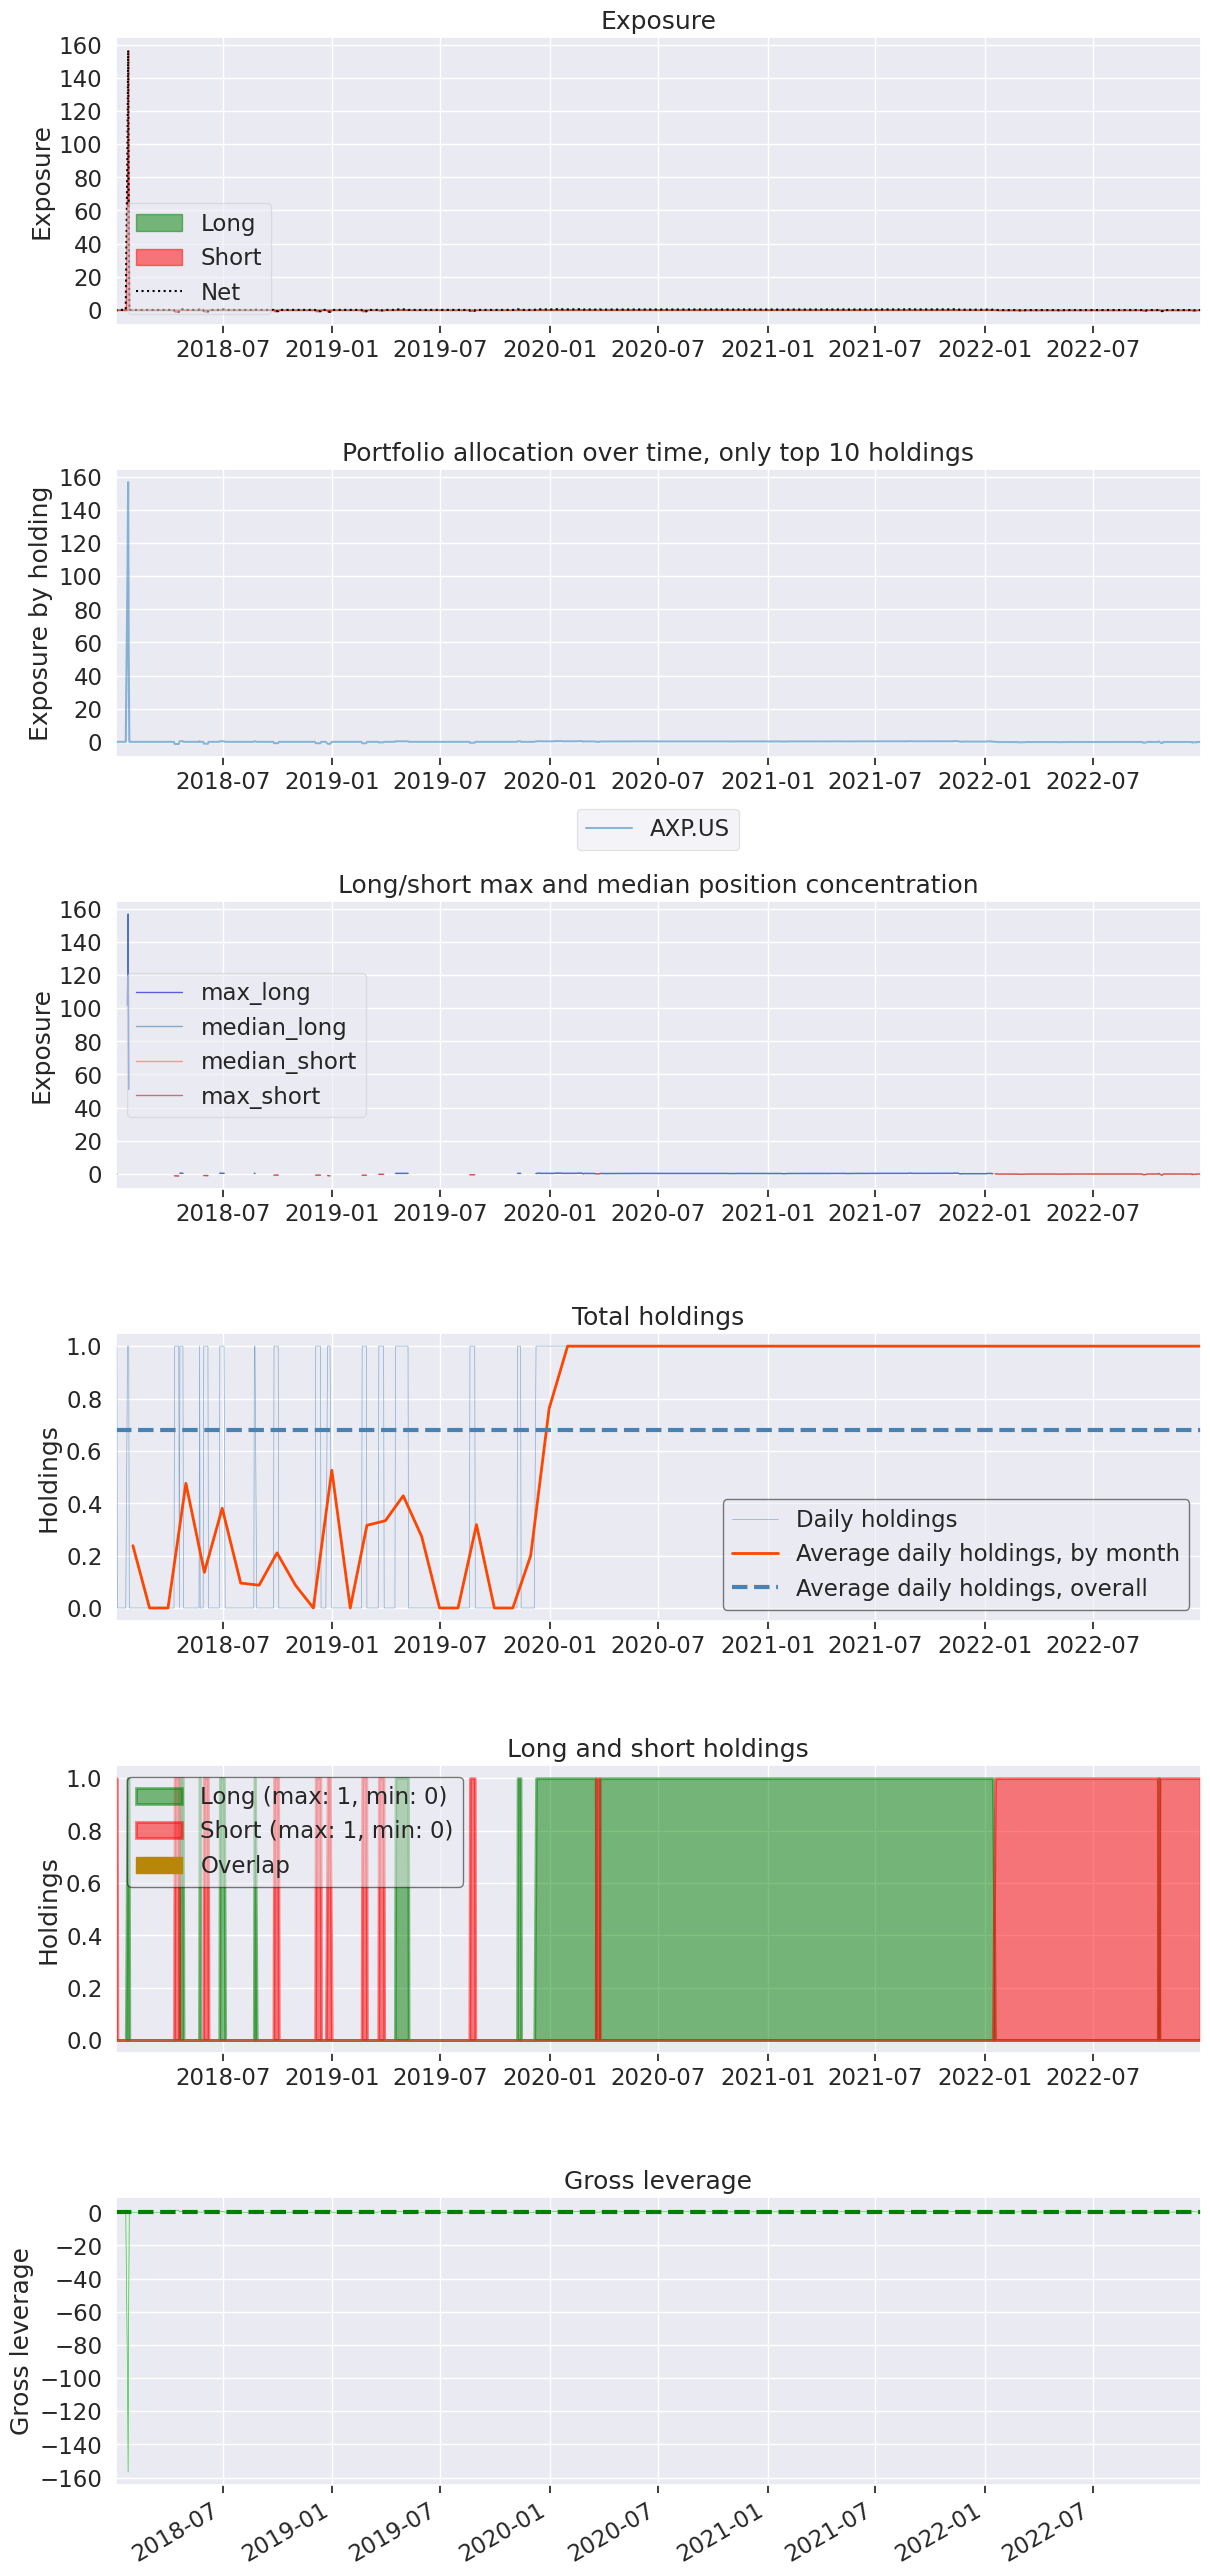

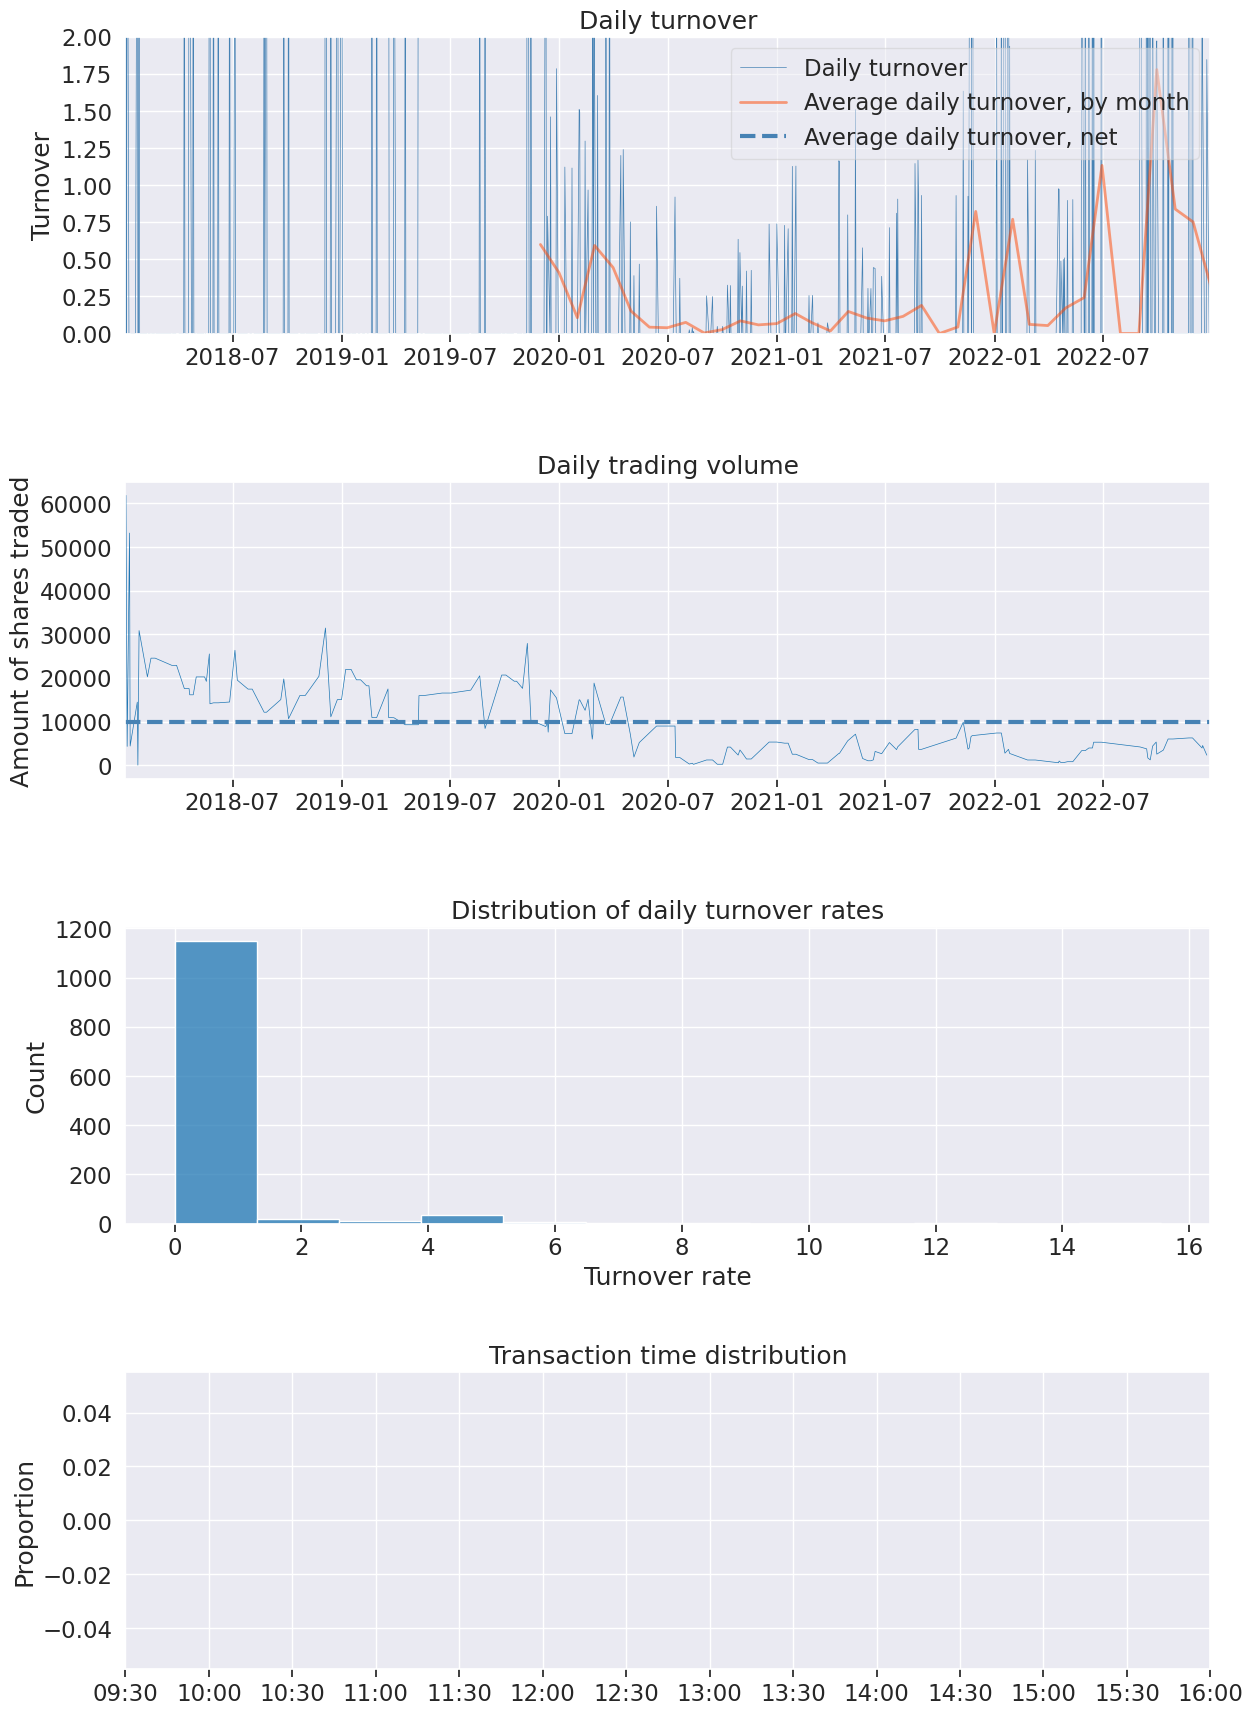

In [27]:
start = str(returns.index.min().year)
end = str(returns.index.max().year + 1)

benchmark = web.DataReader('SP500', 'fred',start = start, end = end).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

pf.create_full_tear_sheet(returns, positions = positions,
                          transactions = transactions, benchmark_rets = benchmark.loc[returns.index],
                          estimate_intraday = False)

Misc

In [99]:
today = trades.index[0]
long_pos = short_pos = 0

In [100]:
trades_sub = trades.loc[today]

In [104]:
long = trades_sub[trades_sub['side'] == 1]
short = trades_sub[trades_sub['side'] == -1]

In [119]:
pf = 1000000
target = pf * (1/ (len(long) + len(short)))

In [112]:
today

Timestamp('2018-01-02 00:00:00')

In [ ]:
def buy(data, size, info):

In [120]:
##enter_pairs(long, long = True)
for s1, s2, hr, period in zip(long.s1, long.s2, long.hedge_ratio, long.period):
    pair_id = f'{s1}.{s2}.period'
    p1 = prices.loc[idx[s1,today],:]['close']
    p2 = prices.loc[idx[s2,today],:]['close']

    size1 = target / p1
    size2 = hr * size1
    print(p1, p2, size1, size2, p1 * size1, p2 * size2)

    info = {'pair':pair_id, 'type': 'open'}
    # o1 = buy(data = s1, size = size1, info = info)
    # o2 = sell(data = s2, size = abs(size2), info = info)
    print()


58.8 190.626 3401.360544217687 -1015.9425597090129 200000.0 -193665.0663870903

25.41 122.018 7870.916961826053 -1568.5807762077636 200000.0 -191395.0891513189



58.8